# How-to Guide: Scattering on Input Parameters

This guide explains how to scatter workflow steps based on input parameters using `ScatterFeatureRequirement` and `MultipleInputFeatureRequirement`. 

The focus is on creating workflows where multiple input parameters are processed in parallel.

## Objective

Scatter the `step_curl` task to process multiple input bands (`red`, `green`, `blue`) in parallel and combine their results in subsequent steps.

## Key Features

1. `ScatterFeatureRequirement`

Enables scattering, allowing parallel execution of workflow steps for array-like inputs.

In [31]:
cwl_file="../cwl-workflows/scatter-input-parameters.cwl"

echo {} | yq -e '{"requirements": {"ScatterFeatureRequirement": {}}}' -

requirements:
  ScatterFeatureRequirement: {}


2. `MultipleInputFeatureRequirement`

Allows using multiple input fields in a workflow.

In [14]:
echo {} | yq -e '{"requirements": {"MultipleInputFeatureRequirement": {}}}' -

requirements:
  MultipleInputFeatureRequirement: {}


3. Scatter on `common_band_name`

Scatters the `step_curl` task based on the `common_band_name` parameter array.

In [24]:
cat $cwl_file | yq e .'$graph[0].steps.step_curl' -

in:
  stac_item: stac-item
  common_band_name: [red-band, green-band, blue-band]
out:
  - hrefs
run: "#stac"
scatter: common_band_name
scatterMethod: dotproduct


## Steps

1. Define the Workflow

The workflow uses default input values for the band names (`red`, `green`, `blue`) and processes them using scattering.

Workflow Inputs

The workflow accepts:

* `stac-item`: URL of a STAC item.
* `red-band`: Band name for the red channel (default: `"red"`).
* `green-band`: Band name for the green channel (default: `"green"`).
* `blue-band`: Band name for the blue channel (default: `"blue"`).

Workflow Outputs

* The final output is the RGB composite TIFF file (`rgb-tif`).

Workflow Definition

In [25]:
cat $cwl_file | yq e . - 

cwlVersion: v1.2
$graph:
  - class: Workflow
    id: main
    requirements:
      InlineJavascriptRequirement: {}
      NetworkAccess:
        networkAccess: true
      ScatterFeatureRequirement: {}
      MultipleInputFeatureRequirement: {}
    inputs:
      stac-item:
        type: string
      red-band:
        type: string
        default: "red"
      green-band:
        type: string
        default: "green"
      blue-band:
        type: string
        default: "blue"
    outputs:
      rgb-tif:
        outputSource: step_color/rgb
        type: File
    steps:
      step_curl:
        in:
          stac_item: stac-item
          common_band_name: [red-band, green-band, blue-band]
        out:
          - hrefs
        run: "#stac"
        scatter: common_band_name
        scatterMethod: dotproduct
      step_stack:
        in:
          tiffs:
            source: step_curl/hrefs
        out:
          - stacked
        run: "#rio_stack"
      step_color:
        in:
          stac

Its graphical representation:

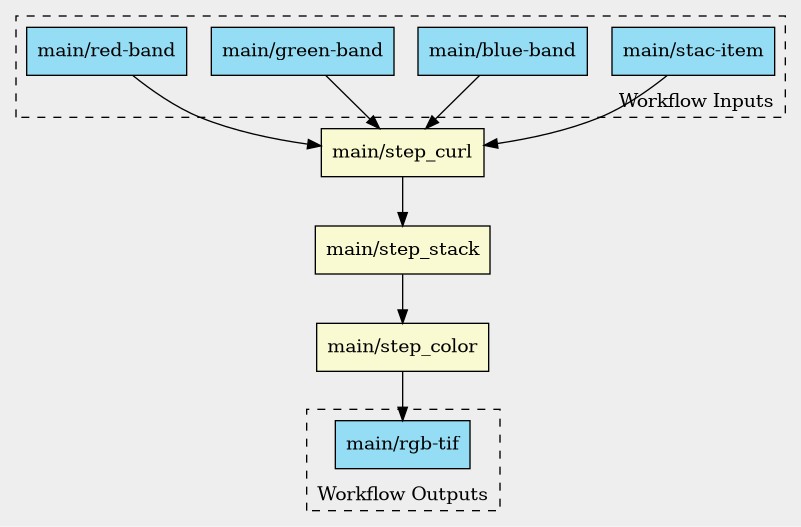

In [26]:
cwltool --print-dot $cwl_file 2> /dev/null | dot -Tpng | display

2. Scatter Configuration

* Step 1: Scatter on `common_band_name`

The `step_curl` step scatters over the `common_band_name` parameter array (`[red-band, green-band, blue-band]`).

In [27]:
cat $cwl_file | yq e .'$graph[0].steps.step_curl' -

in:
  stac_item: stac-item
  common_band_name: [red-band, green-band, blue-band]
out:
  - hrefs
run: "#stac"
scatter: common_band_name
scatterMethod: dotproduct


* `scatter`: Scatters the step over the values of `common_band_name`.
* `scatterMethod: dotproduct`: Matches corresponding elements in the array for parallel execution.

Step 2: Combine Results

The `step_stack` step combines the TIFF files fetched by `step_curl.`

In [29]:
cat $cwl_file | yq e .'$graph[0].steps.step_stack' -

in:
  tiffs:
    source: step_curl/hrefs
out:
  - stacked
run: "#rio_stack"


3. Substeps and Tools

`stac` Tool

* Fetches URLs of the TIFF files corresponding to each band.

`rio_stack` Tool

* Stacks the TIFF files into a single composite file.

4. Run the Workflow

Execute the workflow with the default parameters:

```bash
cwltool scatter-input-parameters.cwl \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A
```

In [9]:


cwltool ../cwl/09-scatter-input-parameters/scatter-input-parameters.cwl --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A > output.json


INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/09-scatter-input-parameters/scatter-input-parameters.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/09-scatter-input-parameters/scatter-input-parameters.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step_curl
INFO [step step_curl] start
INFO [job step_curl] /tmp/2tsxbdar$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/2tsxbdar,target=/xmoJSV \
    --mount=type=bind,source=/tmp/t1k_p8nc,target=/tmp \
    --workdir=/xmoJSV \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/fxi6r5dr/20241211100114-838427.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/xmoJSV \
    docker.io/curlimages/curl:latest \
    curl \
    https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A > /tmp/2tsxbdar/message
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
       

5. Expected Output

Intermediate Outputs:

* `hrefs`: URLs of the TIFF files for `red`, `green`, and `blue` bands.
* `stacked.tif`: Composite TIFF file of all bands.

Final Output:

* `rgb-tif`: RGB composite TIFF file.


In [30]:
cat output.json | yq e . -o=json

{
  "rgb-tif": {
    "location": "file:///data/work/github/eoepca-plus/how-to/docs/rgb.tif",
    "basename": "rgb.tif",
    "class": "File",
    "checksum": "sha1$e18f83a555f6ecf55ab1719b31a59f00c185f433",
    "size": 361747464,
    "path": "/data/work/github/eoepca-plus/how-to/docs/rgb.tif"
  },
  "stack": {
    "location": "file:///data/work/github/eoepca-plus/how-to/docs/stacked.tif",
    "basename": "stacked.tif",
    "class": "File",
    "checksum": "sha1$a9fcfcac28c669f3714eaa4cc59858a28f1e715b",
    "size": 723450636,
    "path": "/data/work/github/eoepca-plus/how-to/docs/stacked.tif"
  }
}


## Key Takeaways

Scattering with Input Parameters:

* The `scatter` field enables parallel execution over array inputs.
* `scatterMethod: dotproduct` ensures corresponding elements in arrays are processed together.


Multiple Input Fields:

* `MultipleInputFeatureRequirement` allows combining multiple input parameters in a single scatter operation.

Parallel and Modular Design:

* Scattering simplifies workflows by enabling parallel processing of input parameters.

This guide demonstrates how to use scattering to process multiple input parameters in parallel within a CWL workflow.